In [3]:
import cv2
import easyocr
import numpy as np
import random
from pathlib import Path
import re
from difflib import get_close_matches
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [4]:
def region(file_path):
    region_codes = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():  
                code, region = line.strip().split(': ')
                region_codes[code] = region
    return region_codes

REGION_CODES = region('region.txt')

print(REGION_CODES)

{'A': 'Banten', 'AA': 'Magelang', 'AB': 'Yogyakarta', 'AD': 'Surakarta', 'AE': 'Madiun', 'AG': 'Kediri', 'B': 'Jakarta', 'BA': 'Sumatera Barat', 'BB': 'Sumatera Utara', 'BD': 'Bengkulu', 'BE': 'Lampung', 'BG': 'Sumatera Selatan', 'BH': 'Jambi', 'BK': 'Sumatera Utara', 'BL': 'Aceh', 'BM': 'Riau', 'BN': 'Kepulauan Bangka Belitung', 'BP': 'Kepulauan Riau', 'CC': 'Corps Consulate', 'CD': 'Corps Diplomatic', 'D': 'Bandung', 'DA': 'Kalimantan Selatan', 'DB': 'Sulawesi Utara Daratan', 'DC': 'Sulawesi Barat', 'DD': 'Sulawesi Selatan', 'DE': 'Maluku', 'DG': 'Maluku Utara', 'DH': 'NTT', 'DK': 'Bali', 'DM': 'Kalimantan Timur', 'DN': 'Sulawesi Tengah', 'DR': 'NTB', 'DS': 'Papua', 'DT': 'Sulawesi Tenggara', 'E': 'Cirebon', 'EA': 'NTB', 'EB': 'NTT', 'ED': 'Sumatra Utara', 'F': 'Bogor', 'G': 'Pekalongan', 'H': 'Semarang', 'K': 'Pati', 'KB': 'Kalimantan Barat', 'KH': 'Kalimantan Tengah', 'KT': 'Kalimantan Timur', 'L': 'Surabaya', 'M': 'Madura', 'N': 'Malang', 'P': 'Besuki', 'R': 'Banyumas', 'RI': 'Ind

In [5]:
def model():
    model_vehicle = YOLO('./model/yolo11n.pt')
    model_plate = YOLO('./model/best.pt')
    reader = easyocr.Reader(['en'], gpu=True)
    return model_vehicle, model_plate, reader


In [6]:
def format_plate_number(text):
    print(f"Formatting plate number: {text}")
    
    text = re.sub(r'[^A-Z0-9]', '', text.upper())
    
    char_substitutions = {
        'O': '0', '0': 'O',
        'I': '1', '1': 'I',
        'Z': '2', '2': 'Z',
        'J': '3', '3': 'J',
        'A': '4', '4': 'A',
        'S': '5', '5': 'S',
        'G': '6', '6': 'G',
        'T': '7', '7': 'T',
        'B': '8', '8': 'B',
    }
    
    def validate_section(text_part, expected_type='alpha'):
        result = ''
        for char in text_part:
            if expected_type == 'alpha' and char.isdigit():
                if char in char_substitutions:
                    result += char_substitutions[char]
                else:
                    result += char
            elif expected_type == 'num' and not char.isdigit():
                if char in char_substitutions:
                    result += char_substitutions[char]
                else:
                    result += char
            else:
                result += char
        return result
    
    number_match = re.search(r'[0-9]{1,4}', text)
    if number_match:
        number_start = number_match.start()
        number_end = number_match.end()
        
        prefix = text[:number_start]
        numbers = text[number_start:number_end]
        suffix = text[number_end:]
        
        prefix = validate_section(prefix, 'alpha')
        numbers = validate_section(numbers, 'num')
        suffix = validate_section(suffix, 'alpha')
        
        if len(prefix) <= 2 and len(numbers) <= 4 and len(suffix) <= 3:
            region_check = get_closest_region_code(prefix)
            if region_check:
                formatted_plate = f"{region_check} {numbers} {suffix}"
                print(f"Formatted plate number: {formatted_plate}")
                return formatted_plate
    
    parts = re.findall(r'[A-Z]+|[0-9]+', text)
    if len(parts) >= 3:
        prefix = validate_section(parts[0], 'alpha')
        numbers = validate_section(parts[1], 'num')
        suffix = validate_section(''.join(parts[2:]), 'alpha')
        
        if len(prefix) <= 2 and len(numbers) <= 4 and len(suffix) <= 3:
            region_check = get_closest_region_code(prefix)
            if region_check:
                formatted_plate = f"{region_check} {numbers} {suffix}"
                print(f"Formatted plate number: {formatted_plate}")
                return formatted_plate
    
    print("No valid Indonesian plate format found")
    return None

In [7]:
def get_closest_region_code(code):
    print(f"Getting closest region code for '{code}'")
    if code in REGION_CODES:
        print(f"Exact match found: {code}")
        return code
    matches = get_close_matches(code, REGION_CODES.keys(), n=1, cutoff=0.6)
    closest_match = matches[0] if matches else None
    if closest_match:
        print(f"Closest match found: {closest_match}")
    else:
        print("No close match found.")
    return closest_match


In [8]:
def edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges

In [9]:
def detect_plates(model_plate, image):
    print("Detecting plates in the image.")
    results = model_plate(image)
    plate_detections = []
    
    for box in results[0].boxes:
        x, y, w, h = box.xywh[0]
        conf = box.conf[0]
        margin = 0.0
        
        x1 = max(0, int(x - w / 2 - margin * w))
        y1 = max(0, int(y - h / 2 - margin * h))
        x2 = min(image.shape[1], int(x + w / 2 + margin * w))
        y2 = min(image.shape[0], int(y + h / 2 + margin * h))
        
        plate_detections.append({
            'bbox': (x1, y1, x2, y2),
            'conf': conf,
            'center': (int(x), int(y)),
            'size': (int(w), int(h))
        })
    
    print(f"Detected {len(plate_detections)} plates.")
    return plate_detections


In [10]:
def enhance_plate_image(plate_img):
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    denoised = cv2.fastNlMeansDenoising(gray)
    
    binary = cv2.adaptiveThreshold(denoised, 255, 
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, 11, 2)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return binary

In [11]:
def process_image(model_vehicle, model_plate, reader, image_path):
    print(f"Processing image: {image_path}")
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result_img = img_rgb.copy()

    vehicles = model_vehicle(img)
    for box in vehicles[0].boxes:
        x, y, w, h = box.xywh[0]
        conf = box.conf[0]
        x1 = max(0, int(x - w / 2))
        y1 = max(0, int(y - h / 2))
        x2 = min(img.shape[1], int(x + w / 2))
        y2 = min(img.shape[0], int(y + h / 2))

        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        label = f"Vehicle {conf:.2f}"
        cv2.putText(result_img, label, (x1, max(y1 - 10, 20)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    plates = detect_plates(model_plate, img)
    plate_texts = []

    for plate in plates:
        x1, y1, x2, y2 = plate['bbox']
        
        if x2 > x1 and y2 > y1:
            plate_crop = img[y1:y2, x1:x2]
            if plate_crop.size > 0:
                plate_text = read_plate(reader, plate_crop)
                
                if plate_text == "Tidak Terbaca":
                    region_name = "Unknown"
                else:
                    region_code = plate_text.split()[0]
                    region_name = REGION_CODES.get(region_code, "Unknown")

                plate_texts.append({
                    'text': plate_text,
                    'conf': plate['conf'],
                    'region': region_name
                })

                cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                label = f"{plate_text} - {region_name}" if plate_text != "Tidak Terbaca" else "Tidak Terbaca"
                cv2.putText(result_img, label, (x1, max(y1 - 10, 20)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return result_img, plate_texts


In [12]:
def read_plate(reader, plate_img):
    print("Reading plate text using OCR.")
    
    rows, cols = plate_img.shape[:2]
    if rows > cols:
        plate_img = cv2.rotate(plate_img, cv2.ROTATE_90_CLOCKWISE)
    
    attempts = [
        plate_img,  
        enhance_plate_image(plate_img),  
        cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY),  
        cv2.threshold(cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY), 
                     0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1],  
    ]
    
    all_texts = []
    
    for img in attempts:
        results = reader.readtext(img, allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
        
        if results:
            for (bbox, text, conf) in results:
                all_texts.append((text, conf))
            
            if len(results) > 1:
                results.sort(key=lambda x: x[0][0][0])  
                combined_text = ''.join(r[1] for r in results)
                avg_conf = sum(r[2] for r in results) / len(results)
                all_texts.append((combined_text, avg_conf))
    
    all_texts.sort(key=lambda x: x[1], reverse=True)
    
    for text, conf in all_texts:
        formatted = format_plate_number(text)
        if formatted:
            print(f"Successfully detected plate: {formatted}")
            return formatted
    
    print("No valid plate text detected")
    return "Tidak Terbaca"

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



Processing image: IMG-20180108-WA0100.jpg
Processing image: test\v2\IMG-20180108-WA0100.jpg

0: 384x640 5 cars, 189.2ms
Speed: 4.8ms preprocess, 189.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Detecting plates in the image.

0: 384x640 1 License Plate, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)
Detected 1 plates.
Reading plate text using OCR.
Formatting plate number: AA8412PB
Getting closest region code for 'AA'
Exact match found: AA
Formatted plate number: AA 8412 PB
Successfully detected plate: AA 8412 PB


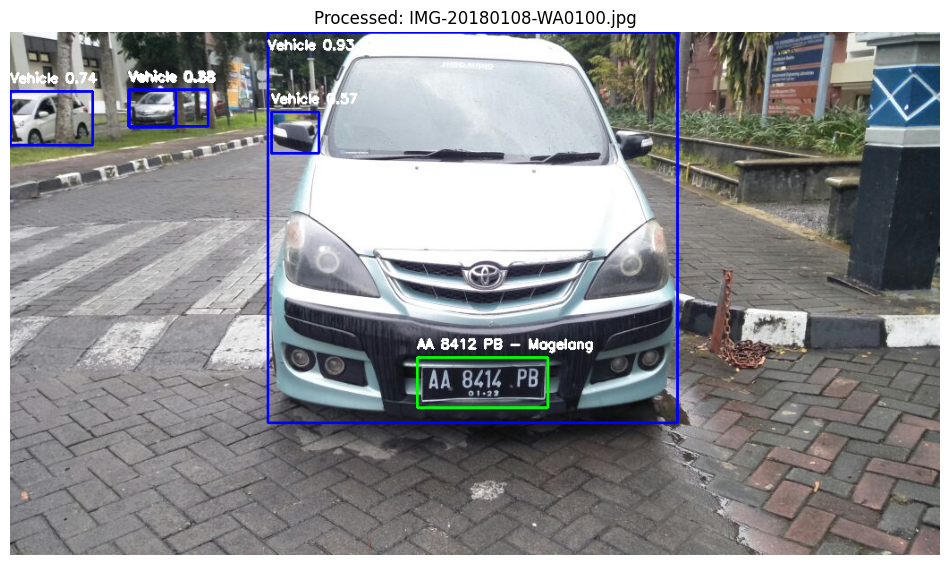

Results saved to: output\result_IMG-20180108-WA0100.png
Detected plates: [{'text': 'AA 8412 PB', 'conf': tensor(0.8988), 'region': 'Magelang'}]


In [14]:
def process_random_image(test_dir='./test/v2/'):
    output_dir = Path('./output')
    output_dir.mkdir(exist_ok=True)
    
    image_files = list(Path(test_dir).glob('*.[jJ][pP][gG]'))
    if not image_files:
        print("No image files found in test directory!")
        return
    
    img_path = random.choice(image_files)
    print(f"\nProcessing image: {img_path.name}")
    
    model_vehicle, model_plate, reader = model()
    try:
        result_img, plate_texts = process_image(model_vehicle, model_plate, reader, img_path)
    except Exception as e:
        print(f"Error processing image {img_path.name}: {e}")
        return
    
    save_path = output_dir / f"processed_{img_path.name}"
    plt.imsave(str(save_path), result_img)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f"Processed: {img_path.name}")
    plt.show()
    plt.close()
    
    output_image_path = output_dir / f"result_{img_path.stem}.png"
    cv2.imwrite(str(output_image_path), cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
    print(f"Results saved to: {output_image_path}")
    
    return plate_texts

plate_texts = process_random_image(test_dir='./test/v2/')
print("Detected plates:", plate_texts)